# VAE for Anomaly Detection

In [25]:
from models import VAE
from data_utils import Binarize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from performance_metrics import plot_roc, plot_normal_vs_anomalous

import torch

import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## Loading and Preprocessing MNIST Data

The original pixel data is reduced to the [0;1] range and then binarized (if the pixel value is larger than 0.5, it is turned to 1, otherwise, to 0). 

Since the objective is detecting anomalies, the images of some number are excluded from the training set, taking a normal behaviour approach.

In [26]:
excluded_number = 3
batch_size = 258

transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize()
])

train_dataset = datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=transform
)

normal_idx = train_dataset.targets != excluded_number
train_dataset.targets = train_dataset.targets[normal_idx]
train_dataset.data = train_dataset.data[normal_idx]

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataset = datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1
)

## The Model

A simple VAE architecture with:
* input layer of dimension 784
* hidden layers of dimension 400
* latent space dimension 40

The latent space is taken to follow a multivariate Guassian distribution with unit Gaussian prior

In [27]:
input_size = 28*28
hidden_size = 400
latent_size = 40
learning_rate = 0.004
epochs = 30

model = VAE(
    input_size=input_size,
    hidden_size=hidden_size,
    latent_size=latent_size
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training the Model

In [28]:
kl_list = list()
recon_list = list()

for e in range(1, epochs+1):
    print(f"Training epoch: {e}")
    model.train()
    
    aux_kl = 0
    aux_recon = 0
    
    for (x, _) in train_loader:
        optimizer.zero_grad()
        x = x.view(-1, input_size)
        x_prime, mu, logvar = model(x)
        kl_loss = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - logvar - 1.0)
        recon_loss = F.binary_cross_entropy(x_prime, x, reduction="sum")
        loss = kl_loss + recon_loss
        
        aux_kl += kl_loss.item()
        aux_recon += recon_loss.item()
        loss.backward()
        optimizer.step()
        
    kl_list.append(aux_kl / len(train_dataset))
    recon_list.append(aux_recon / len(train_dataset))
    
kl_list = np.array(kl_list)
recon_list = np.array(recon_list)

Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10
Training epoch: 11
Training epoch: 12
Training epoch: 13
Training epoch: 14
Training epoch: 15
Training epoch: 16
Training epoch: 17
Training epoch: 18
Training epoch: 19
Training epoch: 20
Training epoch: 21
Training epoch: 22
Training epoch: 23
Training epoch: 24
Training epoch: 25
Training epoch: 26
Training epoch: 27
Training epoch: 28
Training epoch: 29
Training epoch: 30


## Training Results

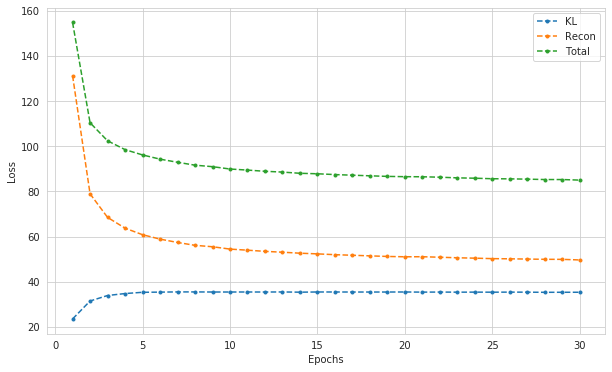

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

e_idx = [e for e in range(1, epochs+1)]

ax.plot(e_idx, kl_list, marker=".", linestyle="--", label="KL")
ax.plot(e_idx, recon_list, marker=".", linestyle="--", label="Recon")
ax.plot(e_idx, kl_list+recon_list, marker=".", linestyle="--", label="Total")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

## Testing for a Contaminated Sample

In [30]:
targets = list()
likelihoods = list()

with torch.no_grad():
    for (x, y) in test_loader:
        x = x.view(-1, input_size)
        x_prime, mu, logvar = model(x)
        kl_loss = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - logvar - 1.0)
        recon_loss = F.binary_cross_entropy(x_prime, x, reduction="sum")
        loss = kl_loss + recon_loss
        targets.append(y.item())
        likelihoods.append(loss.item())
        
targets = np.array(targets)
likelihoods = np.array(likelihoods)

limit = np.quantile(likelihoods, 0.90)
quantile = 1 - len(targets[targets == excluded_number]) / len(targets)

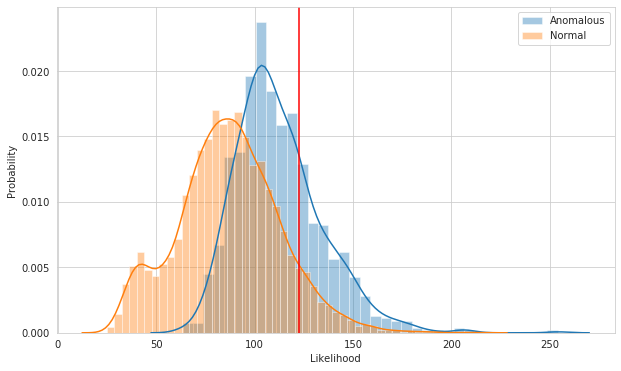

In [31]:
plot_normal_vs_anomalous(targets, likelihoods, excluded_number,quantile)

In [32]:
anomalous_pred = [1 if l > limit else 0 for l in likelihoods]
anomalous_truth = [1 if t == excluded_number else 0 for t in targets]
tn, fp, fn, tp = confusion_matrix(anomalous_truth, anomalous_pred).ravel()

print(f"Recall: {tp / (tp + fn)}")
print(f"Specificity: {tn / (tn + fp)}")
print(f"Precision: {tp / (tp+fp)}")

Recall: 0.2702970297029703
Specificity: 0.9191323692992214
Precision: 0.273


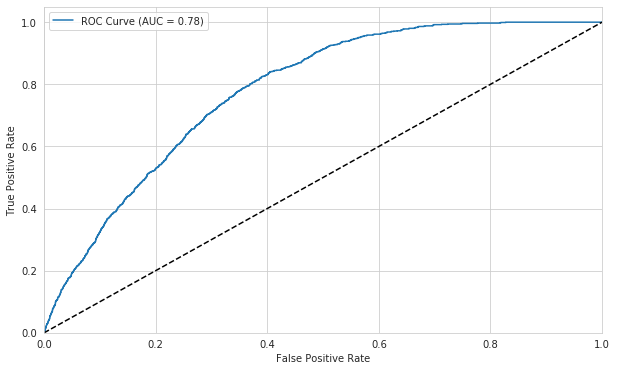

In [33]:
plot_roc(anomalous_truth, likelihoods)

## Excluding Different Numbers

Considering 0 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


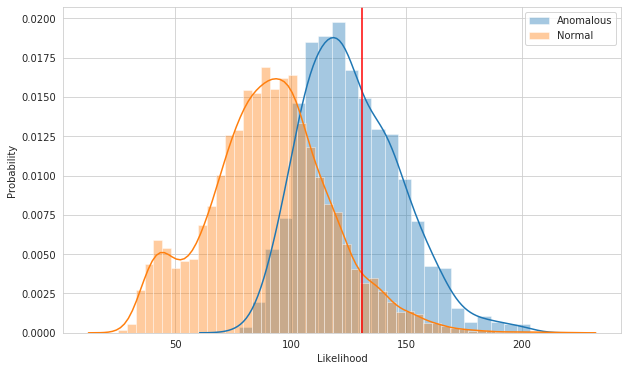

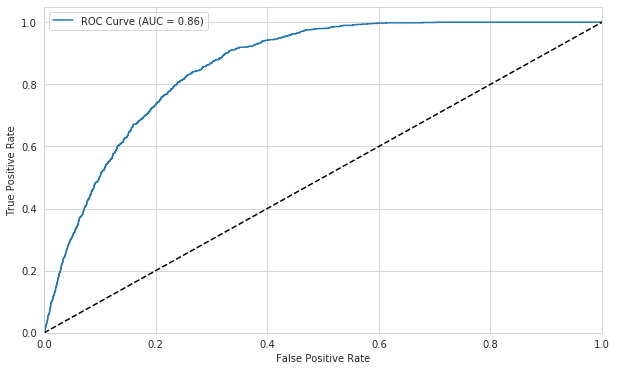

Considering 1 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


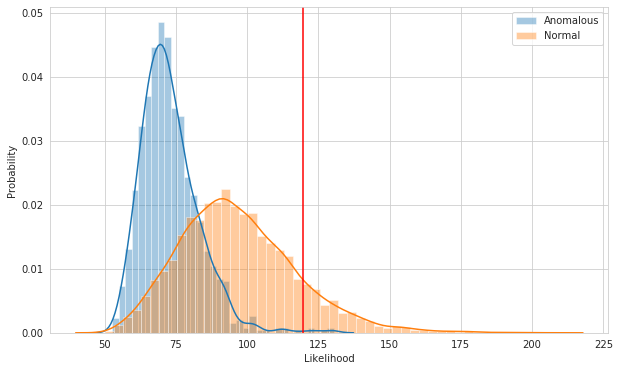

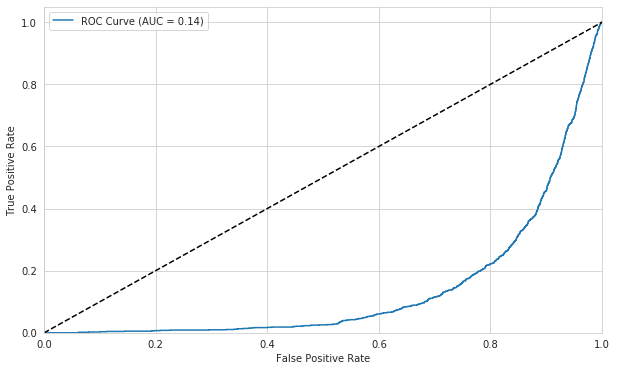

Considering 2 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


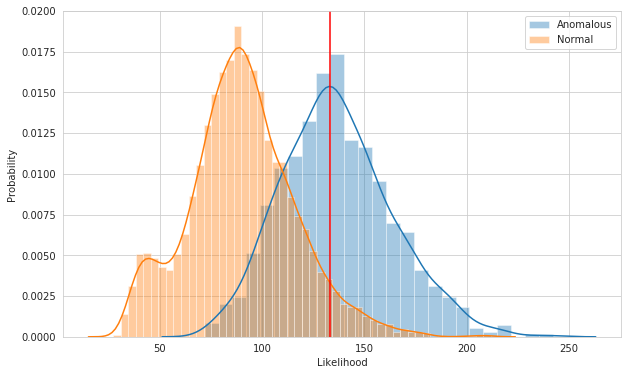

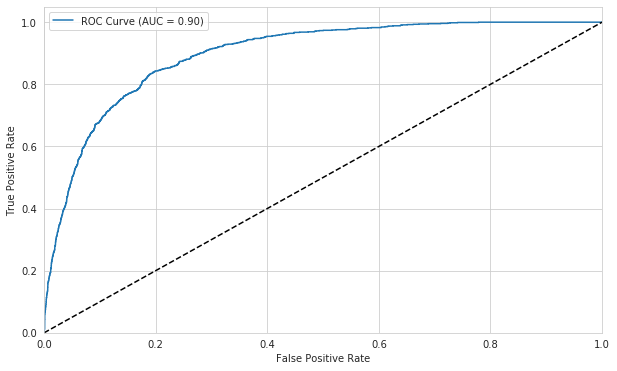

Considering 3 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


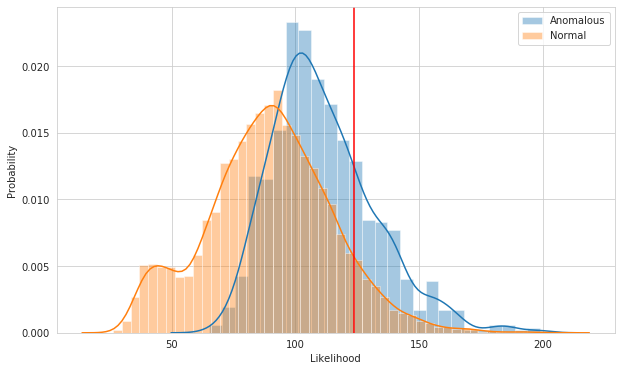

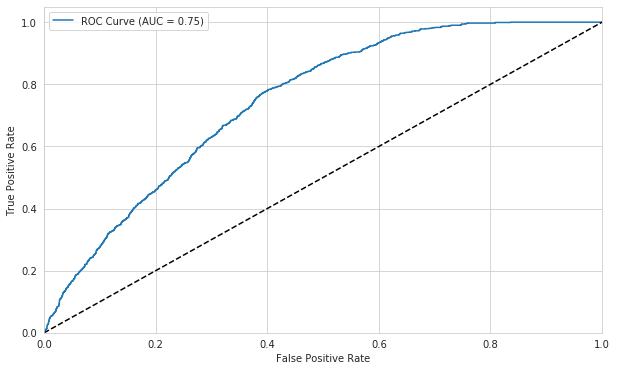

Considering 4 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


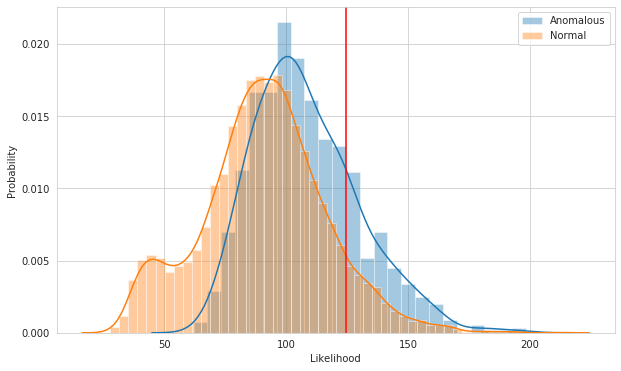

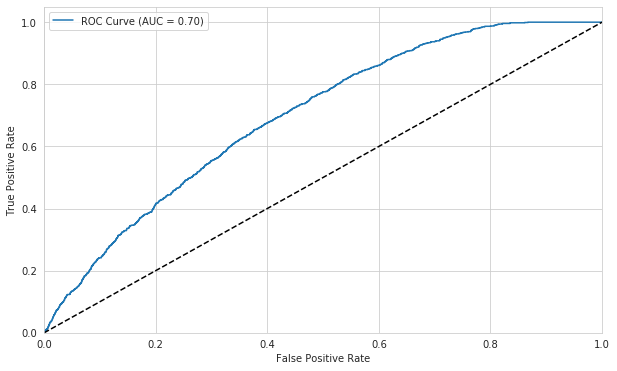

Considering 5 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


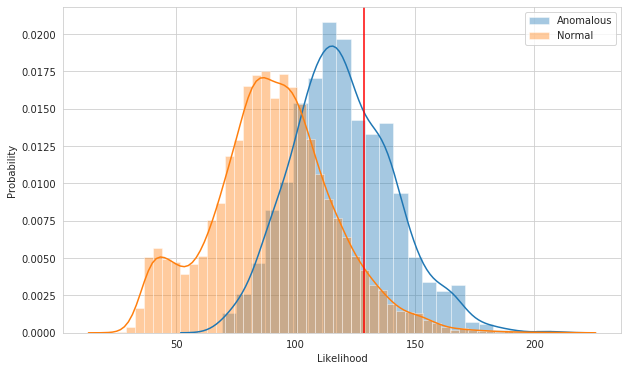

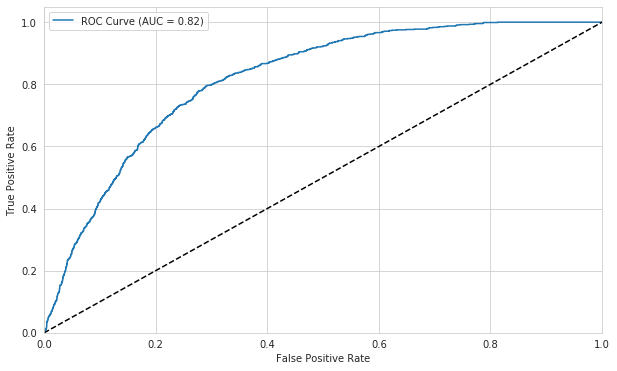

Considering 6 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


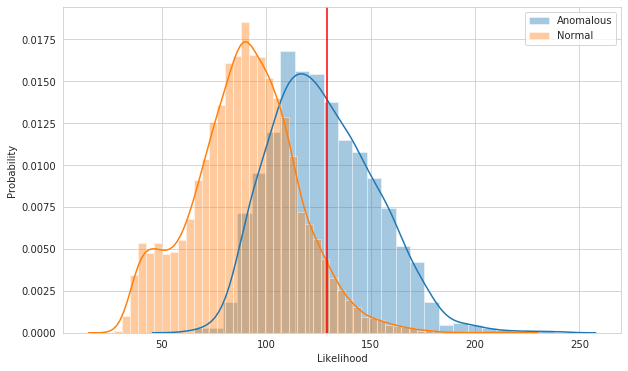

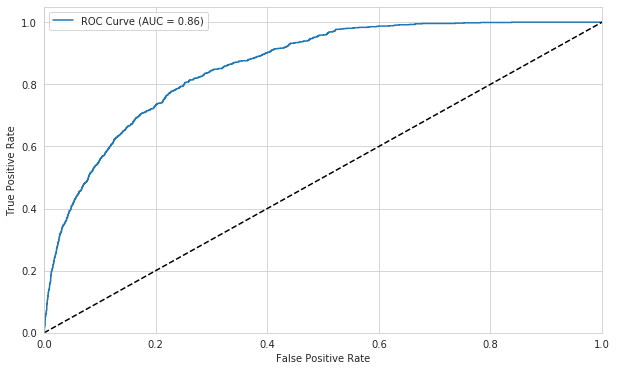

Considering 7 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


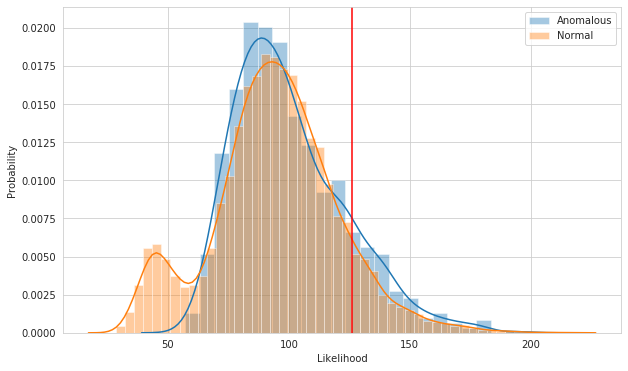

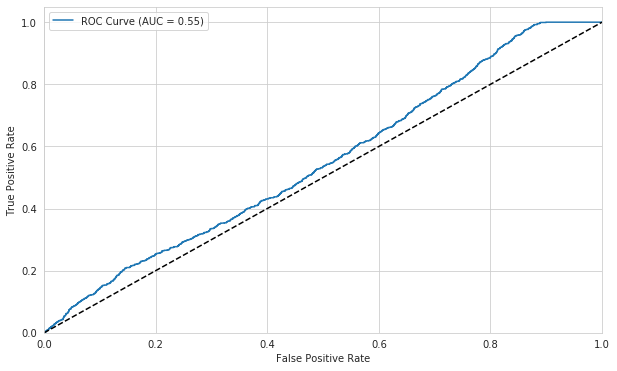

Considering 8 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


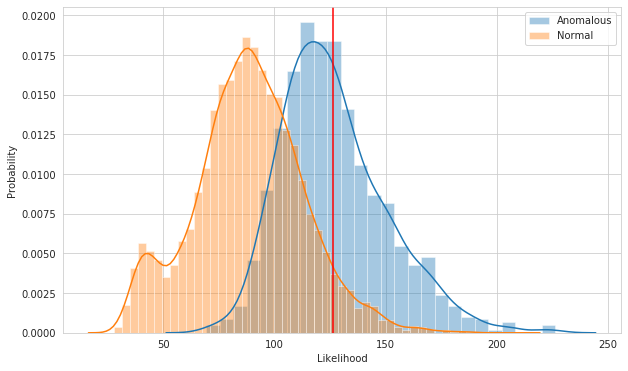

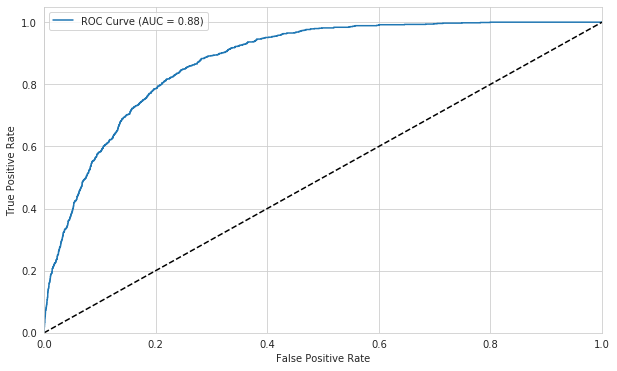

Considering 9 as an anomaly.
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10


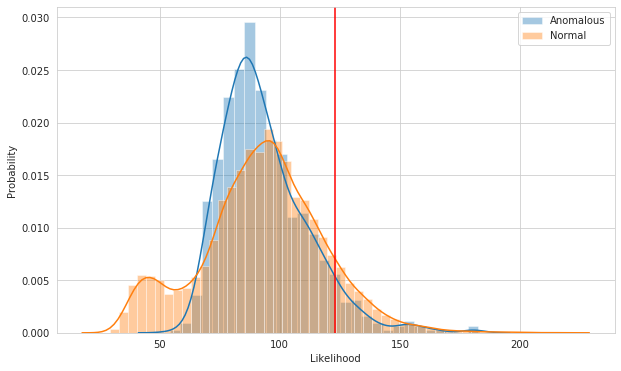

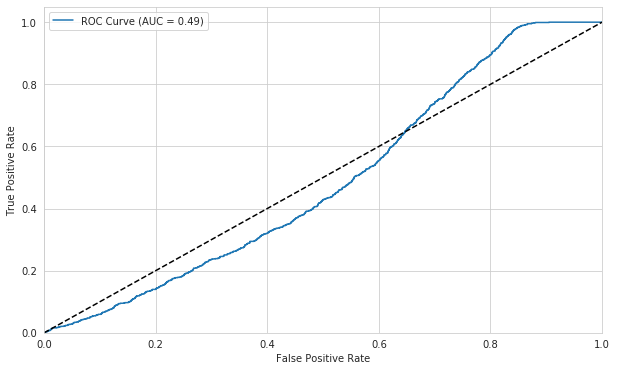

In [8]:
candidates = list(range(0, 10))
for excluded_number in candidates:
    print(f"Considering {excluded_number} as an anomaly.")

    train_dataset = datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transform
    )

    normal_idx = train_dataset.targets != excluded_number
    train_dataset.targets = train_dataset.targets[normal_idx]
    train_dataset.data = train_dataset.data[normal_idx]

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )



    model = VAE(
        input_size=input_size,
        hidden_size=hidden_size,
        latent_size=latent_size
    )

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)



    kl_list = list()
    recon_list = list()

    for e in range(1, epochs+1):
        print(f"Training epoch: {e}")
        model.train()
    
        aux_kl = 0
        aux_recon = 0
    
        for (x, _) in train_loader:
            optimizer.zero_grad()
            x = x.view(-1, input_size)
            x_prime, mu, logvar = model(x)
            kl_loss = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - logvar - 1.0)
            recon_loss = F.binary_cross_entropy(x_prime, x, reduction="sum")
            loss = kl_loss + recon_loss
        
            aux_kl += kl_loss.item()
            aux_recon += recon_loss.item()
            loss.backward()
            optimizer.step()
        
        kl_list.append(aux_kl / len(train_dataset))
        recon_list.append(aux_recon / len(train_dataset))
    
    kl_list = np.array(kl_list)
    recon_list = np.array(recon_list)


    targets = list()
    likelihoods = list()

    with torch.no_grad():
        for (x, y) in test_loader:
            x = x.view(-1, input_size)
            x_prime, mu, logvar = model(x)
            kl_loss = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - logvar - 1.0)
            recon_loss = F.binary_cross_entropy(x_prime, x, reduction="sum")
            loss = kl_loss + recon_loss
            targets.append(y.item())
            likelihoods.append(loss.item())
        
    targets = np.array(targets)
    likelihoods = np.array(likelihoods)

    limit = np.quantile(likelihoods, 0.90)
    quantile = 1 - len(targets[targets == excluded_number]) / len(targets)

    plot_normal_vs_anomalous(targets, likelihoods, excluded_number,quantile)

    anomalous_truth = [1 if t == excluded_number else 0 for t in targets]
    plot_roc(anomalous_truth, likelihoods)